#***GRU***

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import timedelta

# Đọc dữ liệu từ file CSV
file_path = '/content/BNB.csv'
data = pd.read_csv(file_path)

# Hiển thị một vài dòng đầu tiên của dữ liệu
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2019,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,3/2/2019,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,3/3/2019,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,3/4/2019,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,3/5/2019,11.520388,13.841443,11.520388,13.811967,13.811967,237026335


#8:1:1

In [ ]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 8:1:1
train_size = int(len(scaled_prices) * 0.8)
test_size = int(len(scaled_prices) * 0.1)
val_size = len(scaled_prices) - train_size - test_size

train, test, val = scaled_prices[0:train_size], scaled_prices[train_size:train_size+test_size], scaled_prices[train_size+test_size:]

# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình GRU
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
X_val, y_val = create_dataset(val, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình GRU [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))


In [ ]:
# Xây dựng mô hình GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(GRU(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_val, y_val), verbose=2)


Epoch 1/50
1462/1462 - 47s - loss: 0.0017 - val_loss: 9.9928e-04 - 47s/epoch - 32ms/step
Epoch 2/50
1462/1462 - 43s - loss: 0.0010 - val_loss: 0.0014 - 43s/epoch - 29ms/step
Epoch 3/50
1462/1462 - 41s - loss: 9.3607e-04 - val_loss: 0.0013 - 41s/epoch - 28ms/step
Epoch 4/50
1462/1462 - 40s - loss: 7.6556e-04 - val_loss: 9.6184e-04 - 40s/epoch - 28ms/step
Epoch 5/50
1462/1462 - 40s - loss: 7.9053e-04 - val_loss: 0.0020 - 40s/epoch - 27ms/step
Epoch 6/50
1462/1462 - 42s - loss: 7.5438e-04 - val_loss: 0.0013 - 42s/epoch - 29ms/step
Epoch 7/50
1462/1462 - 40s - loss: 7.2221e-04 - val_loss: 7.2897e-04 - 40s/epoch - 27ms/step
Epoch 8/50
1462/1462 - 40s - loss: 6.7206e-04 - val_loss: 8.7248e-04 - 40s/epoch - 27ms/step
Epoch 9/50
1462/1462 - 40s - loss: 6.6225e-04 - val_loss: 7.0708e-04 - 40s/epoch - 27ms/step
Epoch 10/50
1462/1462 - 40s - loss: 6.8329e-04 - val_loss: 8.9664e-04 - 40s/epoch - 28ms/step
Epoch 11/50
1462/1462 - 42s - loss: 6.6081e-04 - val_loss: 6.9248e-04 - 42s/epoch - 29ms/step

In [ ]:
# Dự đoán trên tập test
test_predict = model.predict(X_test)

# Đảo ngược quá trình chuẩn hóa
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test_actual[0], test_predict[:,0])
mae = mean_absolute_error(y_test_actual[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual[0] - test_predict[:,0]) / y_test_actual[0])) * 100

print("MSE: ",mse)
print("MAE: ",mae)
print("RMSE: ",rmse)
print("MAPE: ",mape)


5/5 [==============================] - 0s 13ms/step
MSE:  117.0330507169035
MAE:  10.120571877661702
RMSE:  10.818181488443587
MAPE:  4.49802043930626


In [ ]:
# Get the last 60 days of data for prediction
last_60_days = scaled_prices[-60:]

# Predict the next 30 days
next_30_days = []
for i in range(30):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_30_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 60 days
next_60_days = []
for i in range(60):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_60_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 90 days
next_90_days = []
for i in range(90):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_90_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Inverse transform the predicted values
next_30_days_actual = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1))

print("Predicted prices for the next 30 days:")
print(next_30_days_actual.flatten())

print("\nPredicted prices for the next 60 days:")
print(next_60_days_actual.flatten())

print("\nPredicted prices for the next 90 days:")
print(next_90_days_actual.flatten())

1/1 [==============================] - 0s 29ms/step
Predicted prices for the next 30 days:
[582.54895 594.0712  604.8863  615.5184  625.4151  633.60913 640.96936
 647.5305  653.2165  658.12634 662.41406 666.09674 669.2288  671.896
 674.16235 676.07526 677.6887  679.0494  680.1934  681.1533  681.9583
 682.6325  683.19635 683.6678  684.06177 684.3908  684.66547 684.8949
 685.0865  685.24646]

Predicted prices for the next 60 days:
[685.38025 685.49243 685.5863  685.66504 685.73126 685.7869  685.834
 685.8736  685.90704 685.9353  685.9594  685.98    685.9975  686.01245
 686.0252  686.0362  686.04584 686.05414 686.0613  686.06757 686.0732
 686.0779  686.0821  686.0858  686.0889  686.092   686.0945  686.09686
 686.0989  686.10077 686.1024  686.104   686.1054  686.1066  686.1078
 686.10876 686.1097  686.1105  686.1112  686.1118  686.11237 686.1128
 686.1134  686.1139  686.11414 686.11444 686.11475 686.1148  686.11505
 686.1153  686.1155  686.1157  686.11584 686.11584 686.11597 686.116
 686.1

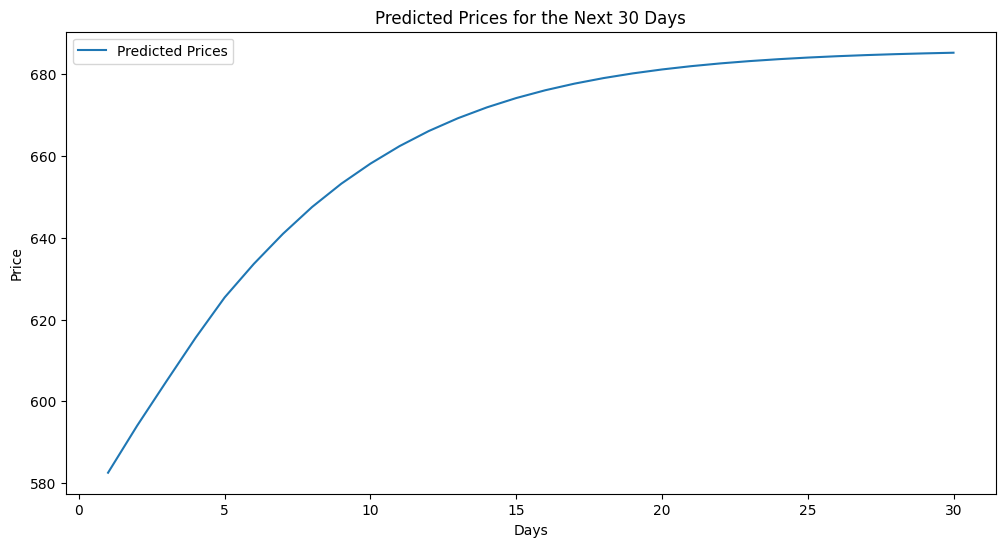

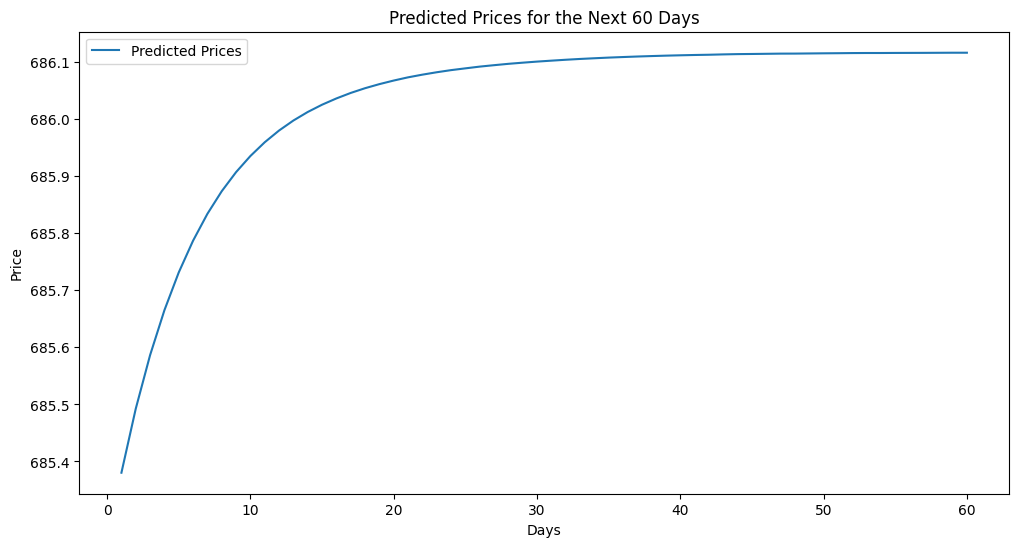

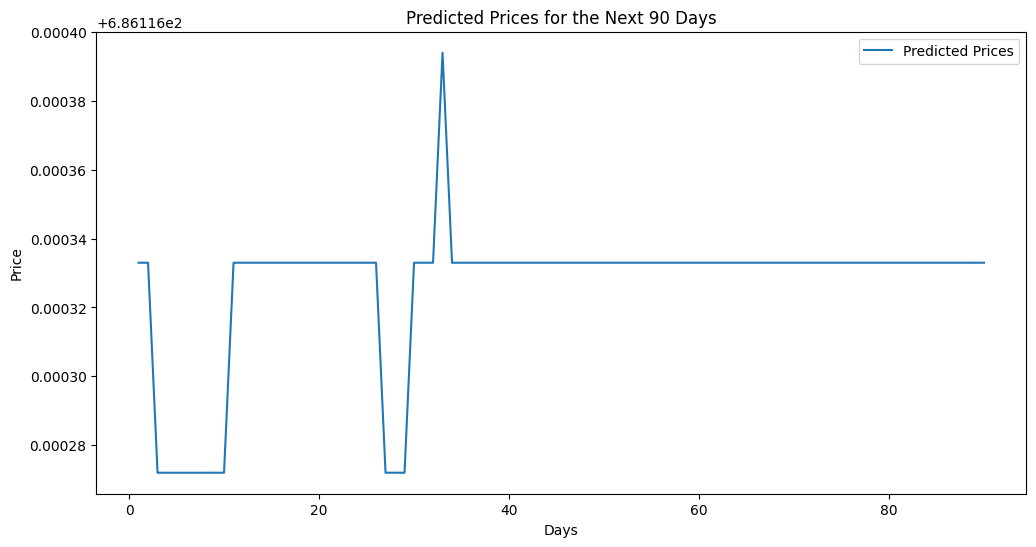

In [ ]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ giá dự đoán 30 ngày
plt.figure(figsize=(12, 6))
plt.plot(predict_days[:30], next_30_days_actual.flatten(), label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30 Days')
plt.legend()
plt.show()

# Vẽ biểu đồ giá dự đoán 60 ngày
plt.figure(figsize=(12, 6))
plt.plot(predict_days[:60], next_60_days_actual.flatten(), label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 60 Days')
plt.legend()
plt.show()

# Vẽ biểu đồ giá dự đoán 90 ngày
plt.figure(figsize=(12, 6))
plt.plot(predict_days[:90], next_90_days_actual.flatten(), label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 90 Days')
plt.legend()
plt.show()

#7:2:1

In [ ]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 7:2:1
train_size = int(len(scaled_prices) * 0.7)
test_size = int(len(scaled_prices) * 0.2)
val_size = len(scaled_prices) - train_size - test_size

train, test, val = scaled_prices[0:train_size], scaled_prices[train_size:train_size+test_size], scaled_prices[train_size+test_size:]

# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình GRU
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
X_val, y_val = create_dataset(val, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình GRU [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))


In [ ]:
# Xây dựng mô hình GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(GRU(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_val, y_val), verbose=2)


Epoch 1/50
1271/1271 - 44s - loss: 0.0021 - val_loss: 0.0019 - 44s/epoch - 34ms/step
Epoch 2/50
1271/1271 - 34s - loss: 0.0011 - val_loss: 9.6655e-04 - 34s/epoch - 27ms/step
Epoch 3/50
1271/1271 - 35s - loss: 9.2065e-04 - val_loss: 0.0015 - 35s/epoch - 28ms/step
Epoch 4/50
1271/1271 - 34s - loss: 8.6027e-04 - val_loss: 8.4775e-04 - 34s/epoch - 26ms/step
Epoch 5/50
1271/1271 - 35s - loss: 8.4398e-04 - val_loss: 0.0011 - 35s/epoch - 27ms/step
Epoch 6/50
1271/1271 - 35s - loss: 8.3492e-04 - val_loss: 7.7731e-04 - 35s/epoch - 28ms/step
Epoch 7/50
1271/1271 - 35s - loss: 8.5359e-04 - val_loss: 6.5568e-04 - 35s/epoch - 27ms/step
Epoch 8/50
1271/1271 - 34s - loss: 7.3778e-04 - val_loss: 9.5699e-04 - 34s/epoch - 27ms/step
Epoch 9/50
1271/1271 - 35s - loss: 8.0521e-04 - val_loss: 7.2804e-04 - 35s/epoch - 28ms/step
Epoch 10/50
1271/1271 - 34s - loss: 7.7397e-04 - val_loss: 0.0021 - 34s/epoch - 26ms/step
Epoch 11/50
1271/1271 - 35s - loss: 7.2443e-04 - val_loss: 7.3499e-04 - 35s/epoch - 28ms/step

In [ ]:
# Dự đoán trên tập test
test_predict = model.predict(X_test)

# Đảo ngược quá trình chuẩn hóa
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test_actual[0], test_predict[:,0])
mae = mean_absolute_error(y_test_actual[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual[0] - test_predict[:,0]) / y_test_actual[0])) * 100

print("MSE: ",mse)
print("MAE: ",mae)
print("RMSE: ",rmse)
print("MAPE: ",mape)


10/10 [==============================] - 1s 14ms/step
MSE:  38.33804024947972
MAE:  4.201311070569039
RMSE:  6.191771979771196
MAPE:  1.5313518697722988


In [ ]:
# Get the last 60 days of data for prediction
last_60_days = scaled_prices[-60:]

# Predict the next 30 days
next_30_days = []
for i in range(30):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_30_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 60 days
next_60_days = []
for i in range(60):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_60_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 90 days
next_90_days = []
for i in range(90):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_90_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Inverse transform the predicted values
next_30_days_actual = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1))

print("Predicted prices for the next 30 days:")
print(next_30_days_actual.flatten())

print("\nPredicted prices for the next 60 days:")
print(next_60_days_actual.flatten())

print("\nPredicted prices for the next 90 days:")
print(next_90_days_actual.flatten())

1/1 [==============================] - 0s 26ms/step
Predicted prices for the next 30 days:
[560.1916  554.3684  543.61835 535.449   529.37445 522.4074  516.28046
 511.18353 506.25354 501.73306 497.7118  493.96677 490.4905  487.294
 484.3126  481.51898 478.90643 476.45285 474.14    471.9581  469.8972
 467.94702 466.0994  464.34723 462.684   461.10364 459.60065 458.16998
 456.8071  455.50784]

Predicted prices for the next 60 days:
[454.26834 453.08493 451.95435 450.8735  449.8397  448.85025 447.90274
 446.995   446.1248  445.29016 444.4895  443.72083 442.9828  442.27383
 441.59244 440.93735 440.3074  439.70132 439.11816 438.55685 438.01636
 437.4958  436.99423 436.51093 436.04514 435.596   435.1629  434.74515
 434.3422  433.95337 433.5781  433.21588 432.86615 432.52844 432.2023
 431.88727 431.5829  431.28876 431.00458 430.72986 430.4643  430.2076
 429.95935 429.71936 429.48727 429.26273 429.04553 428.8354  428.63214
 428.4354  428.24506 428.06082 427.88245 427.70984 427.54272 427.38095


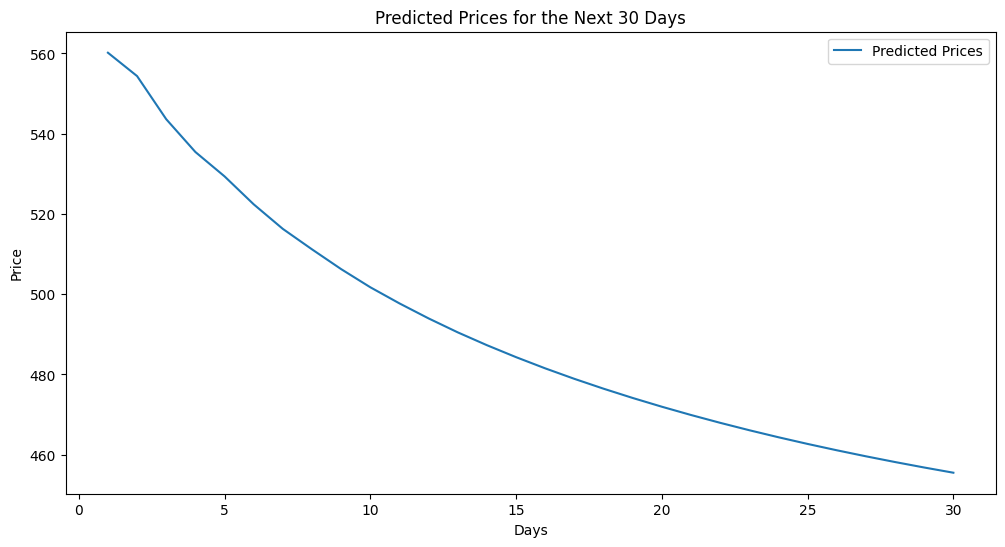

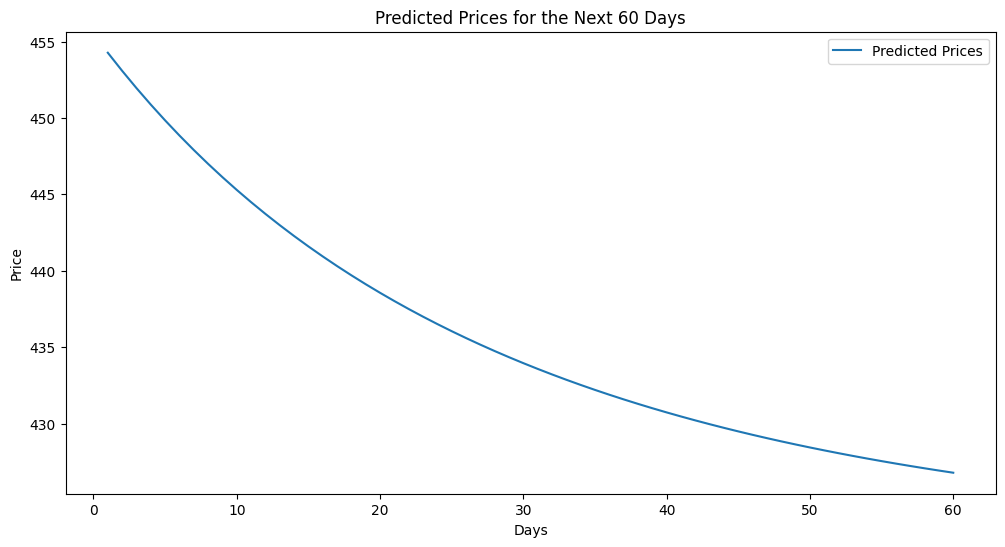

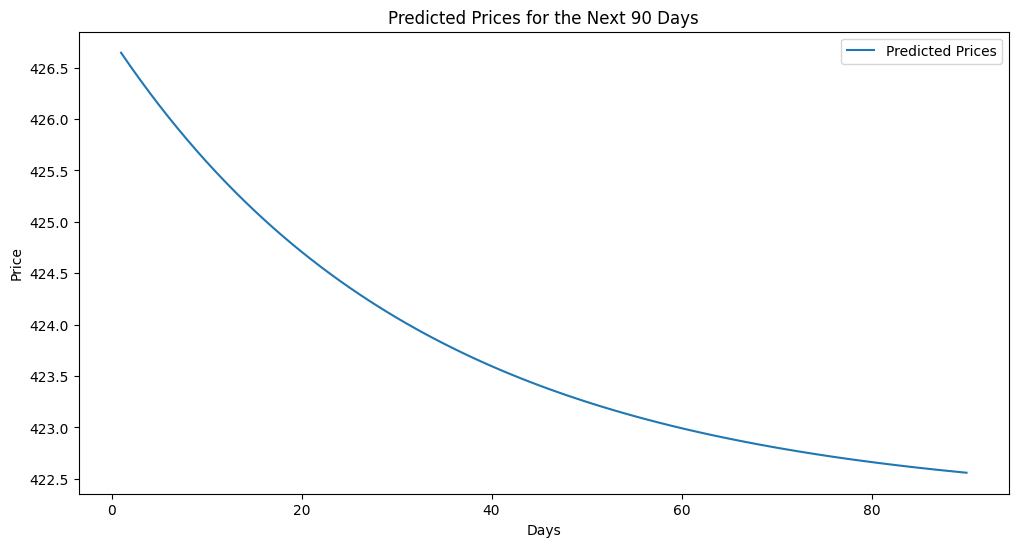

In [ ]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ giá dự đoán 30 ngày
plt.figure(figsize=(12, 6))
plt.plot(predict_days[:30], next_30_days_actual.flatten(), label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30 Days')
plt.legend()
plt.show()

# Vẽ biểu đồ giá dự đoán 60 ngày
plt.figure(figsize=(12, 6))
plt.plot(predict_days[:60], next_60_days_actual.flatten(), label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 60 Days')
plt.legend()
plt.show()

# Vẽ biểu đồ giá dự đoán 90 ngày
plt.figure(figsize=(12, 6))
plt.plot(predict_days[:90], next_90_days_actual.flatten(), label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 90 Days')
plt.legend()
plt.show()

#6:2:2

In [ ]:
# Chỉ lấy cột giá đóng cửa
prices = data['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Phân chia dữ liệu theo tỉ lệ 6:2:2
train_size = int(len(scaled_prices) * 0.6)
test_size = int(len(scaled_prices) * 0.2)
val_size = len(scaled_prices) - train_size - test_size

train, test, val = scaled_prices[0:train_size], scaled_prices[train_size:train_size+test_size], scaled_prices[train_size+test_size:]

# Hàm tạo các tập dữ liệu theo định dạng thích hợp cho mô hình GRU
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
X_val, y_val = create_dataset(val, look_back)

# Định dạng lại dữ liệu đầu vào cho mô hình GRU [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))


In [ ]:
# Xây dựng mô hình GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(GRU(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_val, y_val), verbose=2)


Epoch 1/50
1081/1081 - 36s - loss: 0.0030 - val_loss: 0.0013 - 36s/epoch - 34ms/step
Epoch 2/50
1081/1081 - 31s - loss: 0.0012 - val_loss: 7.1416e-04 - 31s/epoch - 28ms/step
Epoch 3/50
1081/1081 - 31s - loss: 0.0011 - val_loss: 0.0056 - 31s/epoch - 28ms/step
Epoch 4/50
1081/1081 - 32s - loss: 0.0010 - val_loss: 4.1884e-04 - 32s/epoch - 29ms/step
Epoch 5/50
1081/1081 - 32s - loss: 0.0010 - val_loss: 4.2066e-04 - 32s/epoch - 29ms/step
Epoch 6/50
1081/1081 - 32s - loss: 8.9987e-04 - val_loss: 4.3446e-04 - 32s/epoch - 30ms/step
Epoch 7/50
1081/1081 - 31s - loss: 8.6882e-04 - val_loss: 4.8655e-04 - 31s/epoch - 28ms/step
Epoch 8/50
1081/1081 - 34s - loss: 8.4550e-04 - val_loss: 8.2951e-04 - 34s/epoch - 31ms/step
Epoch 9/50
1081/1081 - 31s - loss: 7.8168e-04 - val_loss: 3.4545e-04 - 31s/epoch - 29ms/step
Epoch 10/50
1081/1081 - 31s - loss: 7.7420e-04 - val_loss: 4.6097e-04 - 31s/epoch - 29ms/step
Epoch 11/50
1081/1081 - 32s - loss: 8.0416e-04 - val_loss: 4.1173e-04 - 32s/epoch - 30ms/step
Epo

In [ ]:
# Dự đoán trên tập test
test_predict = model.predict(X_test)

# Đảo ngược quá trình chuẩn hóa
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test_actual[0], test_predict[:,0])
mae = mean_absolute_error(y_test_actual[0], test_predict[:,0])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual[0] - test_predict[:,0]) / y_test_actual[0])) * 100

print("MSE: ",mse)
print("MAE: ",mae)
print("RMSE: ",rmse)
print("MAPE: ",mape)


10/10 [==============================] - 1s 14ms/step
MSE:  80.81442623319121
MAE:  6.170799900598795
RMSE:  8.989684434572284
MAPE:  2.1780387836790016


In [ ]:
# Get the last 60 days of data for prediction
last_60_days = scaled_prices[-60:]

# Predict the next 30 days
next_30_days = []
for i in range(30):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_30_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 60 days
next_60_days = []
for i in range(60):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_60_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Predict the next 90 days
next_90_days = []
for i in range(90):
    X_pred = last_60_days[-look_back:].reshape(1, look_back, 1)
    y_pred = model.predict(X_pred)
    next_90_days.append(y_pred[0,0])
    last_60_days = np.append(last_60_days, y_pred[0,0])
    last_60_days = last_60_days[1:]

# Inverse transform the predicted values
next_30_days_actual = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))
next_60_days_actual = scaler.inverse_transform(np.array(next_60_days).reshape(-1, 1))
next_90_days_actual = scaler.inverse_transform(np.array(next_90_days).reshape(-1, 1))

print("Predicted prices for the next 30 days:")
print(next_30_days_actual.flatten())

print("\nPredicted prices for the next 60 days:")
print(next_60_days_actual.flatten())

print("\nPredicted prices for the next 90 days:")
print(next_90_days_actual.flatten())

1/1 [==============================] - 0s 41ms/step
Predicted prices for the next 30 days:
[541.0044  521.33435 508.03568 491.268   477.19315 468.2958  457.06473
 446.34833 439.01346 430.79895 422.52386 416.28094 410.07202 403.7771
 398.48874 393.54465 388.6604  384.16656 379.98474 375.94647 372.0633
 368.37936 364.84616 361.42786 358.1402  354.97897 351.9278  348.98004
 346.13437 343.38776]

Predicted prices for the next 60 days:
[340.73047 338.15848 335.6709  333.26028 330.9224  328.65533 326.4539
 324.3144  322.23508 320.21152 318.24106 316.3219  314.45078 312.6253
 310.84384 309.104   307.4038  305.74158 304.11563 302.52414 300.96582
 299.439   297.94244 296.47473 295.03476 293.62137 292.23343 290.8698
 289.52954 288.21176 286.91544 285.63983 284.38397 283.14722 281.92865
 280.72784 279.5438  278.37604 277.22385 276.08673 274.96402 273.85522
 272.75967 271.677   270.6067  269.5482  268.50104 267.46487 266.4393
 265.4238  264.41803 263.42154 262.43408 261.4552  260.48456 259.52185
 

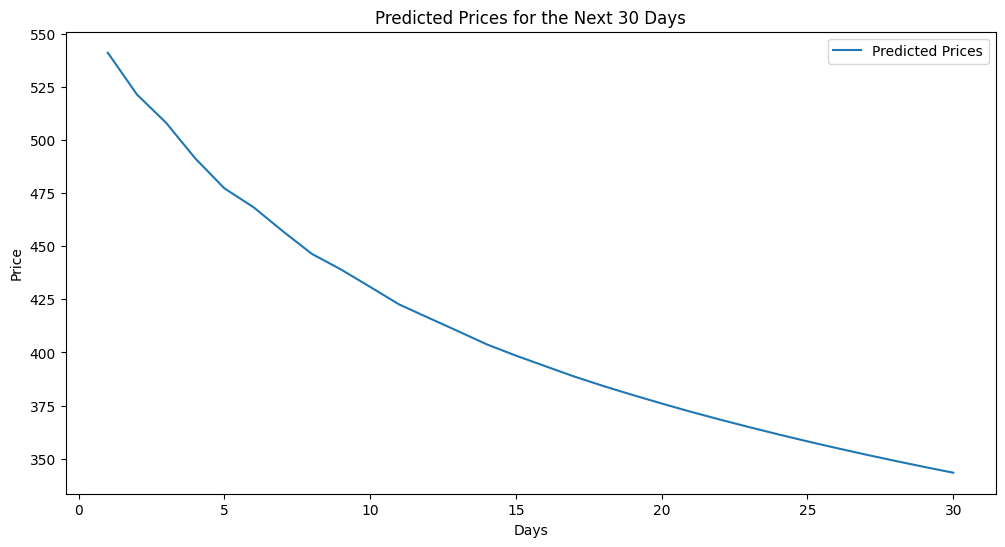

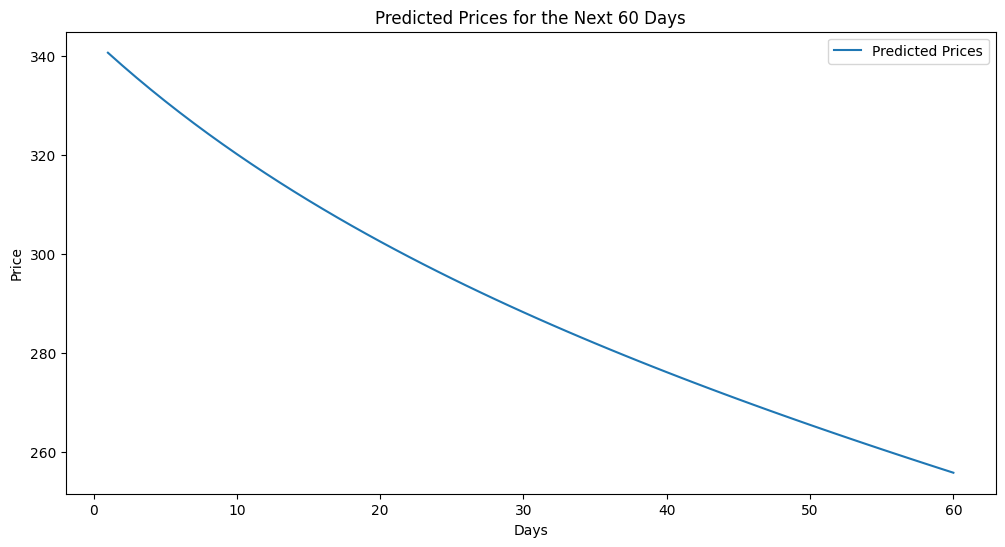

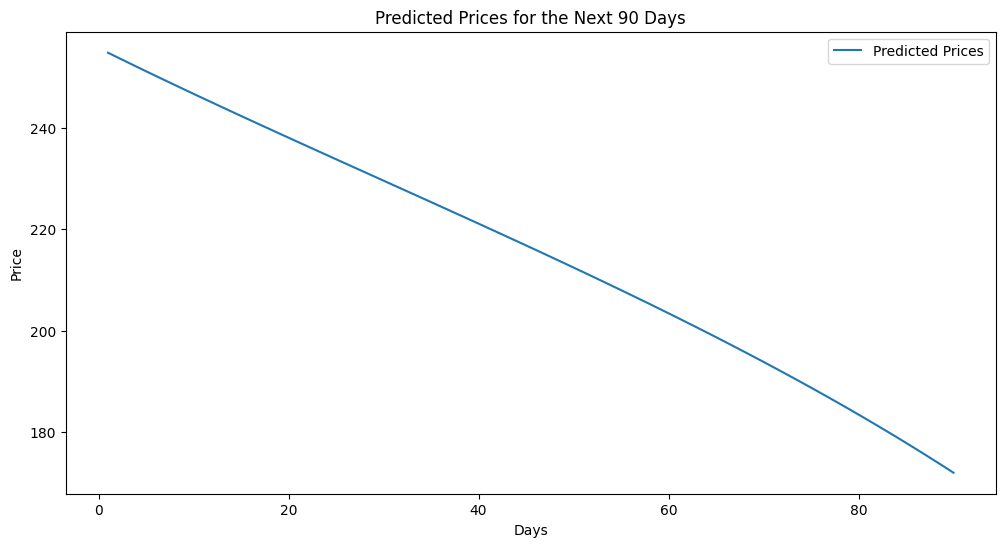

In [ ]:
# Tính toán các ngày dự đoán
predict_days = [i for i in range(1, 91)]

# Vẽ biểu đồ giá dự đoán 30 ngày
plt.figure(figsize=(12, 6))
plt.plot(predict_days[:30], next_30_days_actual.flatten(), label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 30 Days')
plt.legend()
plt.show()

# Vẽ biểu đồ giá dự đoán 60 ngày
plt.figure(figsize=(12, 6))
plt.plot(predict_days[:60], next_60_days_actual.flatten(), label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 60 Days')
plt.legend()
plt.show()

# Vẽ biểu đồ giá dự đoán 90 ngày
plt.figure(figsize=(12, 6))
plt.plot(predict_days[:90], next_90_days_actual.flatten(), label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices for the Next 90 Days')
plt.legend()
plt.show()